***Import Libraries***

In [112]:
import warnings
import gc
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader # type: ignore
from matplotlib import  pyplot as plt
from pypesq import pesq
import metriccs 

%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


***Set noise class to train model***

In [113]:
noise_class=3

In [114]:
TRAIN_INPUT_DIR = Path('Datasets/US_Class2'+str(noise_class)+'_Train_Input')
TRAIN_TARGET_DIR = Path('Datasets/US_Class2'+str(noise_class)+'_Train_Output')
TEST_NOISY_DIR = Path('Datasets/US_Class2'+str(noise_class)+'_Test_Input')
TEST_CLEAN_DIR = Path('Datasets/clean_testset_wav')

In [115]:
np.random.seed(999)
torch.manual_seed(999)

train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

No GPU available, training on CPU.


In [116]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

***Define SpeechDataSet Class***

In [117]:
class SpeechDataset(Dataset):
    
    def __init__(self, noisy_files, target_files, n_fft=64, hop_length=16):
        super().__init__()
        
        self.noisy_files = sorted(noisy_files)
        self.target_files = sorted(target_files)
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        self.max_len = 165000
     
    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        # print(_)
        return waveform
  
    def __getitem__(self, index):

        file_t=self.target_files[index]
        file_n=self.noisy_files[index]
        file_t=str(file_t)
        file_n=str(file_n)
        x_target = self.load_sample(file_t)
        x_noisy = self.load_sample(file_n)
        
        x_target = self._prepare_sample(x_target)
        x_noisy = self._prepare_sample(x_noisy)
        
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, hop_length=self.hop_length,window=torch.ones(N_FFT, device=DEVICE), normalized=True,return_complex=True)
        x_target_stft = torch.stft(input=x_target, n_fft=self.n_fft, hop_length=self.hop_length,window=torch.ones(N_FFT, device=DEVICE), normalized=True,return_complex=True)
        # return 0
        # print(x_noisy_stft)
        return torch.view_as_real(x_noisy_stft), torch.view_as_real(x_target_stft)
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        # print(waveform.shape)
        current_len = waveform.shape[1]
        # print(current_len)
        output = np.zeros((1, self.max_len), dtype='float32')
        # print(output.shape)
        output[0, -current_len:] = waveform[0,:self.max_len]
        output = torch.from_numpy(output)
        # print(output.shape)
        return output

In [118]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

# print("No. of Training files:",len(train_input_files))
# print("No. of Testing files:",len(test_noisy_files))

***Make SpeechDataSet Objects for test and train files***

In [119]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_input_files, train_target_files, N_FFT, HOP_LENGTH)

In [120]:
import matplotlib.pyplot as plt
import librosa

In [121]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    win_length=16,
    hop_length=HOP_LENGTH,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [122]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


In [123]:
# spec=spectrogram(train_dataset.load_sample("Datasets/US_Class3_Test_Input/p232_001.wav"))


In [124]:
# plot_spectrogram(spec[1], title="torchaudio")

***Make Dataloader for train and test dataset***

In [125]:
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=True)
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)

***Define Convolution Class for Complex number For Down Sampling***

In [126]:
class CConv2d(nn.Module):

    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()

        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.stride=stride
        self.real_conv= nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        self.imag_conv = nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.imag_conv.weight)
    def forward(self,x):
        # print(x.shape)
        x_real = x[...,0]
        x_imag= x[...,1]
        c_real = self.real_conv(x_real)-self.imag_conv(x_imag)
        c_imag=self.imag_conv(x_real)+self.real_conv(x_imag)

        output = torch.stack([c_real,c_imag],dim=-1)
        return output


***Define Convolution Class for Complex number For Up Sampling***

In [127]:
class CConvTranspose2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,out_padding=0,padding=0):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.out_padding=out_padding
        self.stride=stride
        
        self.real_convt= nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            stride=self.stride,
                                            output_padding=self.out_padding,
                                            padding=self.padding)
        self.imag_convt=nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            stride=self.stride,
                                            output_padding=self.out_padding,
                                            padding=self.padding)
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.imag_convt.weight)


    def forward(self,x):
        # print(x.shape)
        x_real=x[...,0]
        x_imag=x[...,1]

        c_real=self.real_convt(x_real)-self.imag_convt(x_imag)
        c_imag=self.imag_convt(x_real)+self.real_convt(x_imag)
            
        output=torch.stack([c_real,c_imag],dim=-1)
        
        return output

***Define Batch Normalisation Class***

In [128]:
class CBatchNorm2D(nn.Module):
    def __init__(self,num_features,eps=1e-05,momentum=0.1,affine=True, track_running_stats=True):
        super().__init__()
        self.num_features=num_features
        self.affine=affine
        self.momentum=momentum
        self.eps=eps
        self.track_running_stats=track_running_stats

        self.real_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.imag_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        
    def forward(self,x):
        real=x[...,0]
        imag=x[...,1]

        real_cb=self.real_b(real)
        imag_cb=self.imag_b(imag)

        output=torch.stack([real_cb,imag_cb],dim=-1)
        # print(x.shape)

        return output
    

***Encoder***

Convolution --> Complex Batch Normalisation ---> Activation Function

In [129]:
class Encoder(nn.Module):
    def __init__(self,in_channels=1,out_channels=45,stride=(2,2),kernel_size=(7,5),padding=(0,0)):
        super().__init__()
        self.kernel_size=kernel_size
        self.stride=stride
        self.padding=padding
        self.in_channels=in_channels
        self.out_channels=out_channels

        self.cconv= CConv2d(in_channels=self.in_channels,
                            out_channels=self.out_channels,
                            kernel_size=self.kernel_size,
                            stride=self.stride,
                            padding=self.padding)
        self.cbn=CBatchNorm2D(num_features=self.out_channels)

        self.leaky_relu=nn.LeakyReLU()
        
    def forward(self,x):
        conved=self.cconv(x)
        normed=self.cbn(conved)
        acted=self.leaky_relu(normed)
        # print(acted.shape)
        return acted


***Decoder***

Transposed Convolution --->  Complex Batch Normalisation --->  Activation Function 

In [130]:
class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,out_padding,last_layer):
        super().__init__()

        self.kernel_size = kernel_size
        self.stride_size = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.out_padding = out_padding
        self.padding = padding
        
        self.last_layer = last_layer
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, 
                                       out_channels=self.out_channels, 
                             kernel_size=self.kernel_size,
                               stride=self.stride_size, 
                               out_padding=self.out_padding, 
                               padding=self.padding
                               )
        
        self.cbn = CBatchNorm2D(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

***DCUNET Model Class***

- Define Parameters
- Creates Encoders For Down Sampling
- Creates Decoders For Up Sampling
- Apply Down Sampling and then UpSampling adn return istft Output

In [131]:
class DCUnet(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)
        self.encoders = []
        self.model_length = 20 // 2
        
        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             kernel_size=self.enc_kernel_sizes[i], stride=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 kernel_size=self.dec_kernel_sizes[i], stride=self.dec_strides[i], padding=self.dec_paddings[i],
                                 out_padding=self.dec_output_padding[i],last_layer=False)
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 kernel_size=self.dec_kernel_sizes[i], stride=self.dec_strides[i], padding=self.dec_paddings[i],
                                 out_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)
       
        
    def forward(self, x, is_istft=True):
        orig_x = x
        xs = []
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
        p = x
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            p = torch.cat([p,xs[self.model_length - 1 - i]], dim=1)
        mask = p
        output = mask * orig_x
        output = torch.squeeze(output, 1)
        output=torch.view_as_complex(output)
        if is_istft:
            output = torch.istft(output,n_fft=self.n_fft, hop_length=self.hop_length,
                                 window=torch.ones(N_FFT, device=DEVICE),return_complex=False, 
                                 normalized=True)
        return output

    
    def set_size(self, model_complexity, model_depth=20, input_channels=1):

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3), 
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))

In [132]:
import os
basepath = str(noise_class)+"NoiseToNoise"
os.makedirs(basepath,exist_ok=True)
os.makedirs(basepath+"/Weights",exist_ok=True)
os.makedirs(basepath+"/Samples",exist_ok=True)

***Loss Function***

In [133]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
   
    y_true_ = torch.squeeze(y_true_, 1)
    y_true = torch.istft(torch.view_as_complex(y_true_), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)
    x_ = torch.squeeze(x_, 1)
    x = torch.istft(torch.view_as_complex(x_), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))


    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)


***Train Epoch***

In [134]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    cnt=0
    try:
        for noisy_x, clean_x in train_loader:

            noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

            net.zero_grad()

            pred_x = net(noisy_x)
            loss = loss_fn(noisy_x, pred_x, clean_x)
            loss.backward()
            optimizer.step()
            print(cnt)
            cnt+=1
            train_ep_loss += loss.item() 
            counter += 1
            # print(loss)
            if counter>=5: 
                break
        print("Working ")
        train_ep_loss /= counter

        gc.collect()
        torch.cuda.empty_cache()
        return train_ep_loss
    except:
        train_ep_loss

***Test Epoch***

In [135]:
def test_epoch(net, test_loader, loss_fn):
    try:    
        net.eval()
        test_ep_loss = 0.
        counter = 0.
    
        for noisy_x, clean_x in test_loader:
        

            noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
            pred_x = net(noisy_x)
       
            loss = loss_fn(noisy_x, pred_x, clean_x)

            test_ep_loss += loss.item() 
        
            counter += 1
            # print(loss)
            # print(loss.item())
            #for checking the working of Model
            if counter>=5:
                break
     
        test_ep_loss /= counter
    
    
        gc.collect()
        torch.cuda.empty_cache()
        
        
        return test_ep_loss
    except Exception as error:
        print(error)
        test_ep_loss,{}
        

***Train***

In [136]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    train_losses = []
    test_losses = []
    try:
        
    # print("eme")
        for e in tqdm(range(epochs)):
            print(e)
        # print("sms")
            # if e == 0:
            #     with torch.no_grad():
            #         test_loss = test_epoch(net, test_loader, loss_fn)
                
            #     print("Loss before training:{:.6f}".format(test_loss))
            train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
            test_loss = 0
            scheduler.step()
        
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            torch.save(net.state_dict(), basepath +'/Weights/dc20_model_'+str(e+1)+'.pth')
            torch.save(optimizer.state_dict(), basepath+'/Weights/dc20_opt_'+str(e+1)+'.pth') 
        

            torch.cuda.empty_cache()
            gc.collect()
            print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
            
        return train_losses, test_losses
    except Exception as error:
        print(error) 
        return train_losses, test_losses

***Create Model Object***

With Adam Optimiser

In [137]:
gc.collect()
torch.cuda.empty_cache()
dcunet20 = DCUnet(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())
loss_fn = wsdr_fn
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [138]:
path_to_model="4NoiseToNoise/Weights/dc20_model_5.pth"
path_to_opt="4NoiseToNoise/Weights/dc20_opt_5.pth"
# specify paths and uncomment to resume training from a given point
model_checkpoint = torch.load(path_to_model)
opt_checkpoint = torch.load(path_to_opt)
dcunet20.load_state_dict(model_checkpoint)
optimizer.load_state_dict(opt_checkpoint)

***Train Model***

In [139]:
# train_losses, test_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, 20)

***Plot Loss Vs Epoch***

In [140]:
# print(train_losses)
# f = plt.figure(figsize=(8, 6))
# plt.grid()
# plt.plot(test_losses, label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [141]:
# print(train_losses)
# f = plt.figure(figsize=(8, 6))
# plt.grid()
# plt.plot(train_losses, label='train')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

***Metric***

In [142]:
def pesq_score(net, test_loader):
    net.eval()
    test_pesq = 0.
    counter = 0.


    for noisy_x, clean_x in test_loader:
        
        noisy_x = noisy_x.to(DEVICE)
        with torch.no_grad():
            pred_x = net(noisy_x)
        clean_x = torch.squeeze(clean_x, 1)
        clean_x = torch.istft(torch.view_as_complex(clean_x), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)
        
        
        psq = 0.
        for i in range(len(clean_x)):
            clean_x_16 = torchaudio.transforms.Resample(48000, 16000)(clean_x[i,:].view(1,-1))
            pred_x_16 = torchaudio.transforms.Resample(48000, 16000)(pred_x[i,:].view(1,-1))

            clean_x_16 = clean_x_16.cpu().cpu().numpy()
            pred_x_16 = pred_x_16.detach().cpu().numpy()
            
            
            
            psq += pesq(clean_x_16.flatten(), pred_x_16.flatten(), 16000)
            
        psq /= len(clean_x)
        test_pesq += psq
        counter += 1

    test_pesq /= counter 
    return test_pesq

***Signal Analysis For Clean, Predicted And Noisy***

In [143]:
index = 1

In [144]:
test_noisy_files = sorted(list(Path("Samples/Sample_Test_Input").rglob('*.wav')))
test_clean_files = sorted(list(Path("Samples/Sample_Test_Target").rglob('*.wav')))

test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [145]:
dcunet20.eval()
test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

x_n, x_c = next(test_loader_single_unshuffled_iter)
for _ in range(index):
    x_n, x_c = next(test_loader_single_unshuffled_iter)

x_est = dcunet20(x_n, is_istft=True)

In [146]:
x_est_np = x_est[0].view(-1).detach().cpu().numpy()
x_c_np = torch.istft(torch.view_as_complex(torch.squeeze(x_c[0], 1)), n_fft=N_FFT, hop_length=HOP_LENGTH,window=torch.ones(N_FFT, device=DEVICE),return_complex=False, normalized=True).view(-1).detach().cpu().numpy()
x_n_np = torch.istft(torch.view_as_complex(torch.squeeze(x_n[0], 1)), n_fft=N_FFT, hop_length=HOP_LENGTH,window=torch.ones(N_FFT, device=DEVICE),return_complex=False, normalized=True).view(-1).detach().cpu().numpy()

***Noisy***

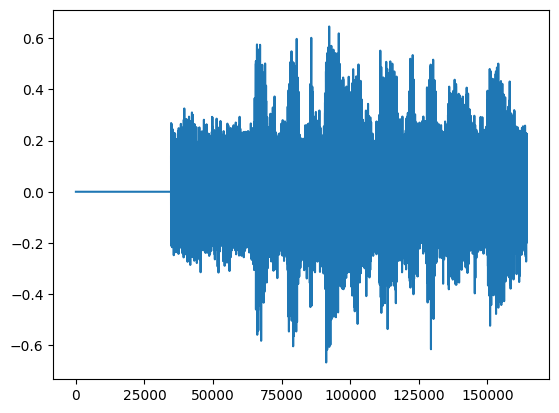

In [147]:
plt.plot(x_n_np)

***Predicted***

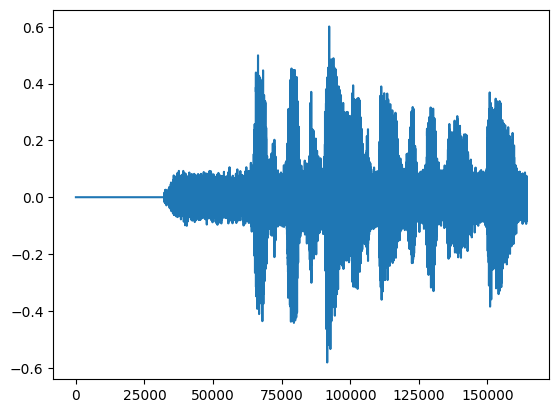

In [148]:
plt.plot(x_est_np)

***Clean***

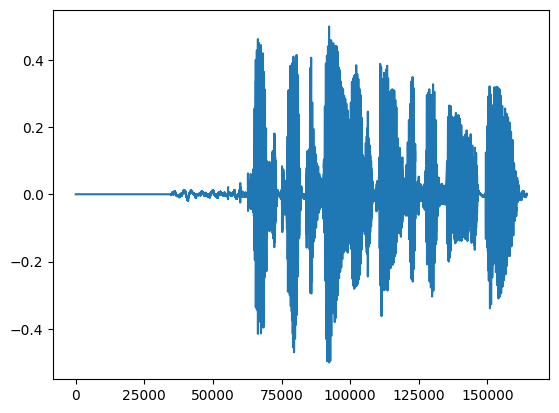

In [149]:
plt.plot(x_c_np)


In [150]:
metric = metriccs.AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)


In [151]:
print(metric.display())

CSIG : 1.000
CBAK : 2.449
COVL : 1.006
PESQ : 1.159
SSNR : -1.202
STOI : 0.675
SNR : 8.054
None


In [152]:

def save_audio_file(np_array=np.array([0.5]*1000),file_path='./sample_audio.wav', sample_rate=48000, bit_precision=16):
    np_array = np.reshape(np_array, (1,-1))
    torch_tensor = torch.from_numpy(np_array)
    torchaudio.save(file_path, torch_tensor, sample_rate,format="wav")
    #torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    # torchaudio.save(uri: Union[BinaryIO, str, PathLike], src: Tensor, sample_rate: int, channels_first: bool = True, format: Optional[str] = None, encoding: Optional[str] = None, bits_per_sample: Optional[int] = None, buffer_size: int = 4096, backend: Optional[str] = None)

In [153]:


# save_audio_file(np_array=x_est_np,file_path=Path("Samples/denoised.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
# save_audio_file(np_array=x_c_np,file_path=Path("Samples/clean.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
# save_audio_file(np_array=x_n_np,file_path=Path("Samples/noisy.wav"), sample_rate=SAMPLE_RATE, bit_precision=16)
from scipy.io.wavfile import write
write("x_est.wav", SAMPLE_RATE, x_est_np.astype(np.float32))
write("x_c.wav", SAMPLE_RATE, x_c_np.astype(np.float32))
write("x_n.wav", SAMPLE_RATE, x_n_np.astype(np.float32))

In [154]:
# model_weights_path = "4NoiseToNoise"

# dcunet20 = DCUnet(N_FFT, HOP_LENGTH).to(DEVICE)
# optimizer = torch.optim.Adam(dcunet20.parameters())

# checkpoint = torch.load(model_weights_path,map_location=torch.device('cpu'))

In [155]:
test_noisy_files = sorted(list(Path("Samples/Sample_Test_Input").rglob('*.wav')))
test_clean_files = sorted(list(Path("Samples/Sample_Test_Target").rglob('*.wav')))

test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)

# For testing purpose
test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [156]:
# dcunet20.load_state_dict(checkpoint)

In [157]:
index = 4

In [158]:
dcunet20.eval()
test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

x_n, x_c = next(test_loader_single_unshuffled_iter)
for _ in range(index):
    x_n, x_c = next(test_loader_single_unshuffled_iter)

x_est = dcunet20(x_n, is_istft=True)

In [159]:
x_est_np = x_est[0].view(-1).detach().cpu().numpy()
x_c_np = torch.istft(torch.squeeze(x_c[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
x_n_np = torch.istft(torch.squeeze(x_n[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()

RuntimeError: istft requires a complex-valued input tensor matching the output from stft with return_complex=True.

In [ ]:
metrics = metriccs.AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
print(metrics.display())

In [ ]:
plt.plot(x_n_np)

In [ ]:
plt.plot(x_est_np)

In [ ]:
plt.plot(x_c_np)